## Dry years plot for East Kimberley region

#this code uses one of the large Geofabric polygons

This notebook starts by using gridded daily BoM data to find wet and dry years using the available BoM data (oct 1987 - oct 2012). We find driest years as the driest Oct-Oct period (hydrological year) for the rainfall grid. This is done by taking the yearly average of the daily rainfall, then plotting the minimum value by value and also by year.

Edit:


** Code dependencies **
-code needs to be run in Python 3, unlike the geomedian which currently relies on Python2
- csv file containing the bounding boxes for the case study site/s
OR
- polygon with the extents desired


Based on rainfall code originally created by Claire Krause in November 2016 using Datacube version 1.1.13 & Python v3
Modified by Bex Dunn March 2017.
Bex edit to include a polygon over which to calculate the wet and dry years, from the BOM Geofabric, Surface Hydrolgy Catchments http://www.bom.gov.au/water/geofabric/

In [1]:
%matplotlib inline

In [2]:
#%matplotlib notebook 

# Import libraries
import os
import pickle
import datacube
import numpy as np
import xarray as xr
import scipy.stats
import pandas
import csv
import logging
#not sure if we need date time in addition to pandas
import datetime

#libraries for polygon and polygon mask
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
from datacube.storage.masking import mask_valid_data as mask_invalid_data

#get shapely for dealing with polygons, descartes for plotting and matplotlib patches to fill in the polygon
from matplotlib.collections import PatchCollection
from descartes import PolygonPatch
from shapely.geometry import MultiPolygon

#Libraries for plots
import matplotlib.pyplot as plt
from matplotlib import colors
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import seaborn as sns

#module for writing to netcdf
from datacube.storage.storage import write_dataset_to_netcdf
from osgeo import gdal

#python logging 
logging.getLogger('datacube.storage.storage').setLevel(logging.ERROR)
dc = datacube.Datacube(app='dc-BOMrainfall')

In [3]:
def warp_geometry(geom, src_crs, dst_crs):
    """
    warp geometry from src_crs to dst_crs
    source co-ordinate reference system to destination coordinate reference system
    """
    return shapely.geometry.shape(rasterio.warp.transform_geom(src_crs, dst_crs, shapely.geometry.mapping(geom)))

#mask to use with our polygons to calculate wet and dry years 
#(comes from http://agdc-v2.readthedocs.io/en/stable/user/guide.html#code-recipes)
def geometry_mask(geoms, geobox, all_touched=False, invert=False):
    """
    Create a mask from shapes.

    By default, mask is intended for use as a
    numpy mask, where pixels that overlap shapes are False.
    :param list[Geometry] geoms: geometries to be rasterized
    :param datacube.utils.GeoBox geobox:
    :param bool all_touched: If True, all pixels touched by geometries will be burned in. If
                             false, only pixels whose center is within the polygon or that
                             are selected by Bresenham's line algorithm will be burned in.
    :param bool invert: If True, mask will be True for pixels that overlap shapes.
    """
    return rasterio.features.geometry_mask([geom.to_crs(geobox.crs) for geom in geoms],
                                           out_shape=geobox.shape,
                                           transform=geobox.affine,
                                           all_touched=all_touched,
                                           invert=invert)

In [4]:
#pick a shape file. or #FIXME work out how to iterate over shapes in a shapefile
shape_file = '/home/547/njs547/shapefiles/EK_AEM_10km_buffert.shp'
with fiona.open(shape_file) as shapes:
    geom_crs = geometry.CRS(shapes.crs_wkt)
    first_geo = next(iter(shapes))['geometry']
    #first_geo = next(shapes)['geometry']
    #geopolygon = geometry.Geometry(geom, geom_crs)
    geom = geometry.Geometry(first_geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(next(iter(shapes))['geometry'])
    
shape_name = shape_file.split('/')[-1].split('.')[0]

In [5]:
query = {
        'time': ('1976-07-01','2017-07-01'),
#          'x': (geom.bounds[0], geom.bounds[2]),
#          'y': (geom.bounds[1], geom.bounds[3]),
        'geopolygon': geom 
#         'crs': geom_crs,
    }

## Load `bom_rainfall` grids from the datacube (or from file)

In [6]:
#setup rain directory where we have put our pickle data
rainpath ='/g/data1/zk34/njs547/Rainfall_EK'

this was taking ages on friday?!?

In [7]:
try:
        os.mkdir(rainpath)
except OSError as err:
        print("OS error: {0}".format(err))

OS error: [Errno 17] File exists: '/g/data1/zk34/njs547/Rainfall_EK'


In [8]:
try:
    #try to get the rain data from a pickle file saved earlier
    f = open(rainpath+'/Rainfall_data'+'.pkl', 'rb')
    rain = pickle.load(f)
    Studysite_rain = rain['Studysite_rain']
    print('loaded rainfall grids from file:'+rainpath+'Rainfall_data.pkl')
    f.close()
except:
    #Grab bom_rainfall_grids from the datacube
    print('loading bom rainfall grids from datacube')
    Studysite_rain = dc.load(product = 'bom_rainfall_grids', **query)
    #make a dictionary of the data we want to save
    vars2pickle = {'Studysite_rain':Studysite_rain}
    f = open(rainpath+'/Rainfall_data'+'.pkl', 'wb')
    pickle.dump(vars2pickle,f) 
    print('saving rainfall data to file')
    #pickle.dump(vars2pickle,f,protocol = 2, fix_imports = True) #maintain compatibility with python 2
    f.close()

loaded rainfall grids from file:/g/data1/zk34/njs547/Rainfall_EKRainfall_data.pkl


## Resample to monthly values, using the mean
The totally yearly rainfall (or sum over time) would seem to make sense, but our first and last year are incomplete, and are thus not able to be compared to all the others. It's nicer to not lose the data from them by using mean, rather than excluding them.

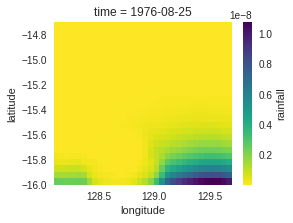

In [9]:
#Mask the data with the polygon. Invert = True means you want the contents of the mask
#I've added 'all touched = True, otherwise we get nothing in the output.
mask = geometry_mask([geom], Studysite_rain.geobox, all_touched=True,invert=True)
Studysite_rain_masked = Studysite_rain.where(mask)
#Plot at t[-1]
plt.figure(figsize=(4,3))
fig = Studysite_rain_masked.rainfall.isel(time = [55]).plot()
#reverse the colourmap so high rainfall is blue
fig.set_cmap('viridis_r')
#print (Studysite_rain_masked)
plt.show()

In [10]:
#resample xarray Dataset Studysite_rain by Month'MS' 
month_sum = Studysite_rain_masked.resample('MS', dim='time', how='sum', keep_attrs=True)

In [11]:
print(month_sum)

<xarray.Dataset>
Dimensions:    (latitude: 26, longitude: 32, time: 450)
Coordinates:
  * longitude  (longitude) float64 128.1 128.2 128.2 128.3 128.3 128.4 128.4 ...
  * latitude   (latitude) float64 -14.73 -14.78 -14.83 -14.88 -14.93 -14.98 ...
  * time       (time) datetime64[ns] 1976-07-01 1976-08-01 1976-09-01 ...
Data variables:
    rainfall   (time, latitude, longitude) float32 0.0108383 0.0118007 ...
Attributes:
    crs:      EPSG:4326


## Plot rainfall by month

<xarray.DataArray 'time' (time: 450)>
array(['1976-07-01T00:00:00.000000000', '1976-08-01T00:00:00.000000000',
       '1976-09-01T00:00:00.000000000', ..., '2013-10-01T00:00:00.000000000',
       '2013-11-01T00:00:00.000000000', '2013-12-01T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1976-07-01 1976-08-01 1976-09-01 ...


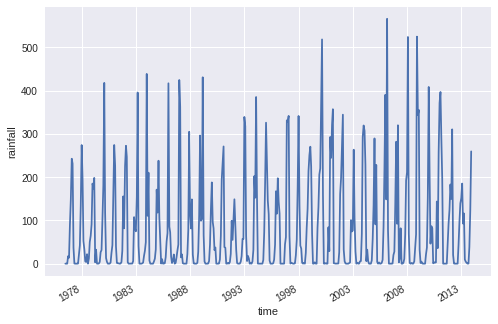

In [12]:
month_sum.rainfall.mean(dim=('latitude', 'longitude')).plot()
print(month_sum.time)
plt.show()

In [13]:
# This function calculates the residual mass rainfall curve

def calculate_residual_mass_curve(a):
    # find the number of time steps
    
    n = len(a.rainfall.time)/12
    
    # First calculate a cumulative rainfall xarray
    
    arr = a.rainfall.values
    
    cum_rf = np.cumsum(arr, axis = 0)
    
    cum_rf_xr = xr.DataArray(cum_rf, dims = ('time', 'latitude', 'longitude'),
                              coords = [a.time, a.latitude, a.longitude])
    
    # Find the average of all months
    ave_months = a.rainfall.groupby('time.month').mean('time').values
    
    # Since we are starting with a water year we need to reorder the array so that July is first

    wy_month_ave = np.concatenate((ave_months[6:,:,:], ave_months[0:6,:,:]), axis = 0)

    print(np.shape(wy_month_ave))
    # Can certainly use tile here but will do a number of years rather than on n as defined here
    tiled_ave = np.tile(wy_month_ave, (round(n), 1, 1))
    
    if (n).is_integer() == False:
        month_remainder = int(round((n%1) * 12))

        tiled_ave = tiled_ave[:int(-month_remainder),:,:]
        

    cum_ave = np.cumsum(tiled_ave, axis = 0)
    
    cum_ave_xr = xr.DataArray(cum_ave, dims = ('time', 'latitude', 'longitude'),
                              coords = [a.time, a.latitude, a.longitude])
    
    mass_res_curve = cum_rf_xr - cum_ave_xr
    
    return mass_res_curve
 


(12, 26, 32)


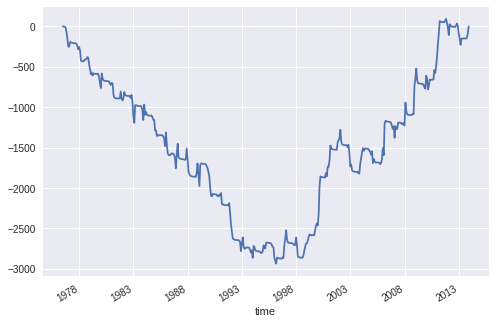

In [14]:
mass_res_curve = calculate_residual_mass_curve(month_sum)    

mass_res_curve.mean(dim = ('latitude', 'longitude')).plot()


plt.show()

It is clear that the 80s and 90s were generally a dry period (relatively continuous below average rainfall) before a wet period fromt he late 90s into the 2010s with some particular wet periods indicated by a steep upward slope (eg. ~2001).

In [15]:
# Find the year with the lowest and highest residual mass
yearly_ave_mr = mass_res_curve.groupby('time.year').mean(dim = 'time')

# These xarrays have the index of the lowest year
min_yr = yearly_ave_mr.argmin(dim = 'year', keep_attrs = True)
# Add the minimum year to the array

min_yr = min_yr + yearly_ave_mr.year.min()

max_yr = yearly_ave_mr.argmax(dim = 'year', keep_attrs = True)

max_yr = max_yr + yearly_ave_mr.year.min()

print(max_yr)

<xarray.DataArray (latitude: 26, longitude: 32)>
array([[1976, 1976, 1976, ..., 2011, 2011, 2011],
       [1976, 1976, 1976, ..., 2011, 2011, 2011],
       [1976, 1976, 1976, ..., 2011, 2011, 2011],
       ..., 
       [2012, 2012, 2012, ..., 2011, 2011, 2011],
       [2012, 2012, 2012, ..., 2011, 2011, 2011],
       [2012, 2012, 2012, ..., 2011, 2011, 2011]])
Coordinates:
  * latitude   (latitude) float64 -14.73 -14.78 -14.83 -14.88 -14.93 -14.98 ...
  * longitude  (longitude) float64 128.1 128.2 128.2 128.3 128.3 128.4 128.4 ...


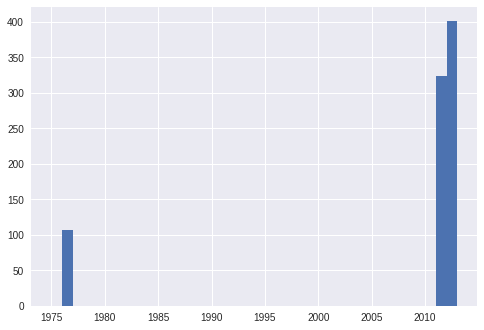

In [16]:
# Find the years with the 
max_distr = max_yr.values.reshape([-1])

plt.hist(max_distr, np.arange(max_distr.min() - 1, max_distr.max() + 2))
plt.show()

As the maximum is around 2012 

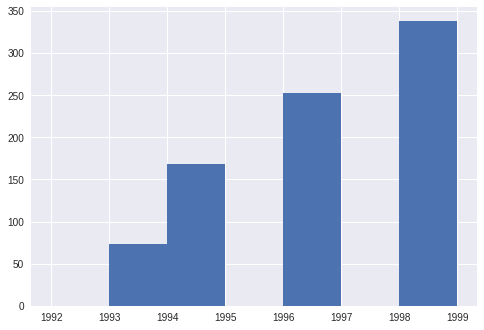

In [17]:
min_distr = min_yr.values.reshape([-1])
plt.hist(min_distr, np.arange(min_distr.min() - 1, min_distr.max() + 2))
plt.show()

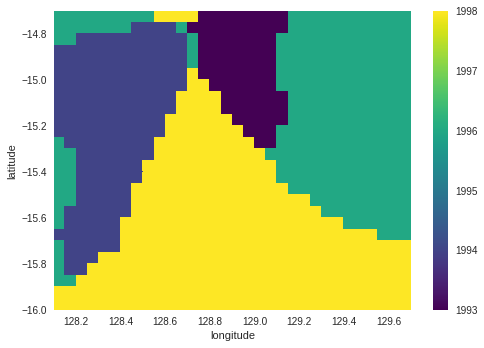

In [18]:
# Now lets investigate the spatial distribution

min_yr.plot.pcolormesh()
plt.show()

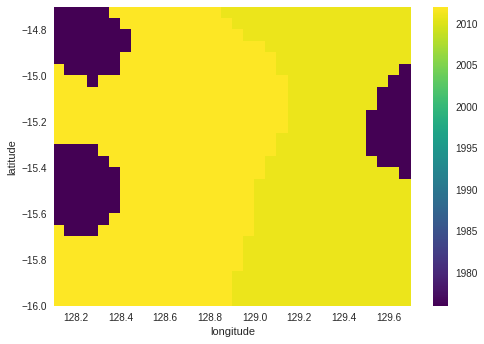

In [19]:
max_yr.plot.pcolormesh()
plt.show()

In [20]:
# Export the minimum year xarray
f = open('/g/data1/zk34/njs547/Rainfall_EK/rmc_driest_yr_EK.pkl', 'wb')
pickle.dump(min_yr, f)

In [21]:
# Now save it as a netcdf
nc_file = '/home/547/njs547/driest_year_EK.nc'

min_yr.to_netcdf(nc_file)



In [31]:
# Try creating a netcdf for every year that appears in the netcdf file

unique_yrs = np.unique(min_yr.values)


nc_dict = {}

for item in unique_yrs:
    nc_dict[item] = min_yr.where(min_yr == item)



In [37]:
root = '/home/547/njs547/netCDF_files/'

for item in nc_dict:
    fname = root + str(item) + '.nc'
    nc_dict[item].to_netcdf(fname)

In [38]:
min_yr

<xarray.DataArray (latitude: 26, longitude: 32)>
array([[1996, 1996, 1996, ..., 1996, 1996, 1996],
       [1996, 1996, 1996, ..., 1996, 1996, 1996],
       [1996, 1996, 1994, ..., 1996, 1996, 1996],
       ..., 
       [1996, 1996, 1998, ..., 1998, 1998, 1998],
       [1998, 1998, 1998, ..., 1998, 1998, 1998],
       [1998, 1998, 1998, ..., 1998, 1998, 1998]])
Coordinates:
  * latitude   (latitude) float64 -14.73 -14.78 -14.83 -14.88 -14.93 -14.98 ...
  * longitude  (longitude) float64 128.1 128.2 128.2 128.3 128.3 128.4 128.4 ...